<a href="https://colab.research.google.com/github/mkkim007/AIFFEL/blob/main/%5BE_08%5DPortraitMode.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [E-08] 인물사진을 만들어 보자

## 1. 데이터(사진) 준비하기

In [1]:
import cv2
import numpy as np
import os
import tarfile
import urllib   # 웹에서 데이터를 다운로드 할 때

from matplotlib import pyplot as plt
import tensorflow as tf

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
! mkdir /content/images

In [4]:
! cp /content/gdrive/MyDrive/Data/나1.jpg /content/images
! cp /content/gdrive/MyDrive/Data/cat.jpg /content/images

(750, 1000, 3)


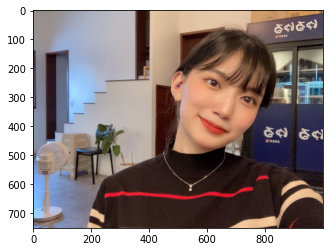

In [5]:
import os
img_path ='/content/images/나1.jpg'  # 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요. 
img_orig = cv2.imread(img_path) 
print (img_orig.shape)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

## 2. 세그멘테이션으로 사람 분리하기

### 2.1 세그멘테이션(Segmentation)이란?


Image Segmentation  : 이미지에서 픽셀 단위로 관심 객체를 추출하는 방법  

Semantic Segmentation : 세그멘테이션 중에서도 특히 우리가 인식하는 세계처럼 물리적 의미 단위로 인식하는 세그멘테이션 -> 이미지에서 픽셀을 사람, 자동차, 비행기 등 물리적 단위로 분류하는 방법  

Instance Segmentation : 시맨틱 세그멘테이션에서 더 나아가 사람을 개개인별로 다른 레벨을 가지게 한다. 


### 2.2 시맨틱 세그멘테이션 다뤄보기


Semantic segmentation을 해결 하기 위한 방법론은 여러가지(FCN, SegNet, U-Net 등등)가 존재한다.  
그 중에서도 가장 높은 성능을 보이고 있는 DeepLab 알고리즘(DeepLab v3+)을 먼저 살펴보자

In [6]:
class DeepLabModel(object):
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    # __init__()에서 모델 구조를 직접 구현하는 대신, tar file에서 읽어들인 그래프구조 graph_def를 
    # tf.compat.v1.import_graph_def를 통해 불러들여 활용하게 됩니다. 
    def __init__(self, tarball_path):
        self.graph = tf.Graph()
        graph_def = None
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()

        with self.graph.as_default():
    	    tf.compat.v1.import_graph_def(graph_def, name='')

        self.sess = tf.compat.v1.Session(graph=self.graph)

    # 이미지를 전처리하여 Tensorflow 입력으로 사용 가능한 shape의 Numpy Array로 변환합니다.
    def preprocess(self, img_orig):
        height, width = img_orig.shape[:2]
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = cv2.resize(img_orig, target_size)
        resized_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
        img_input = resized_rgb
        return img_input
        
    def run(self, image):
        img_input = self.preprocess(image)

        # Tensorflow V1에서는 model(input) 방식이 아니라 sess.run(feed_dict={input...}) 방식을 활용합니다.
        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME: [img_input]})

        seg_map = batch_seg_map[0]
        return cv2.cvtColor(img_input, cv2.COLOR_RGB2BGR), seg_map

In [7]:
# define model and download & load pretrained weight
_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'

model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
tf.io.gfile.makedirs(model_dir)

print ('temp directory:', model_dir)

download_path = os.path.join(model_dir, 'deeplab_model.tar.gz')
if not os.path.exists(download_path):
    urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + 'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
                   download_path)

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

temp directory: /root/aiffel/human_segmentation/models
model loaded successfully!


In [8]:
img_resized, seg_map = MODEL.run(img_orig)
print (img_orig.shape, img_resized.shape, seg_map.max())

(750, 1000, 3) (384, 513, 3) 16


In [9]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

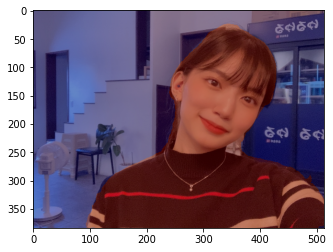

In [10]:
img_show = img_resized.copy()
seg_map = np.where(seg_map == 15, 15, 0) # 예측 중 사람만 추출
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

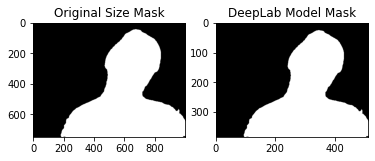

In [11]:
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

## 3. 배경 흐리게 하기

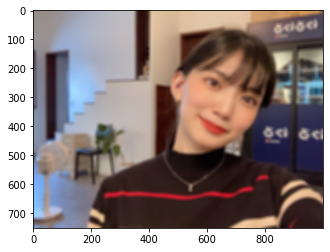

In [12]:
img_orig_blur = cv2.blur(img_orig, (13,13)) #(13,13)은 blurring  kernel size를 뜻합니다. 
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

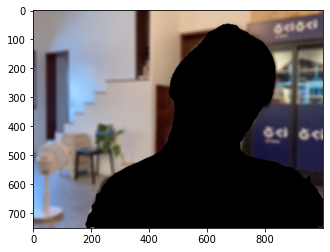

In [13]:
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

## 4. 배경과 원본 이미지 합성

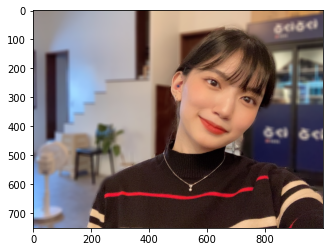

In [14]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

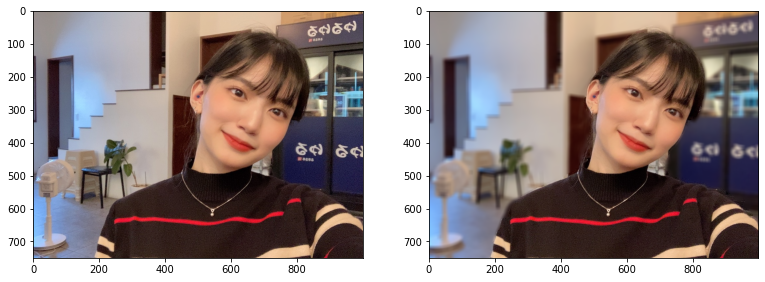

In [15]:
fig = plt.figure(figsize=(13,13))
ax1 = fig.add_subplot(1,2,1)
ax1.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
ax2 = fig.add_subplot(1,2,2)
ax2.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))

## 5. 크로마키

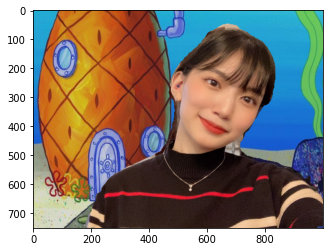

In [16]:
img_bg = cv2.imread("/content/gdrive/MyDrive/Data/backgorund.jpg")
img_bg = cv2.resize(img_bg, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
img_concat = np.where(img_mask_color==255, img_orig, img_bg)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

## 6. 고양이 아웃포커싱

In [17]:
img_cat = cv2.imread("/content/gdrive/MyDrive/Data/cat.jpg")
img_resized, cat_map = MODEL.run(img_cat)
print (img_cat.shape, img_resized.shape, seg_map.max())

(1334, 1334, 3) (513, 513, 3) 15


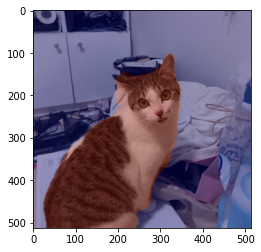

In [18]:
img_show = img_resized.copy()
cat_map = np.where(cat_map == 8, 8, 0) # 예측 중 고양이만 추출
img_mask = cat_map * (255/cat_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

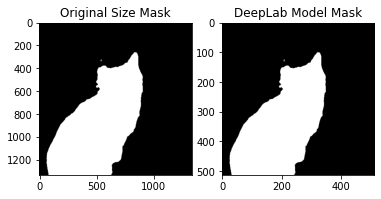

In [19]:
img_mask_up = cv2.resize(img_mask, img_cat.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

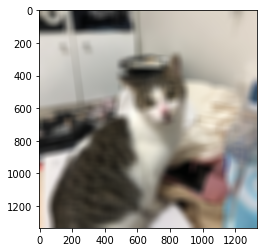

In [20]:
img_cat_blur = cv2.blur(img_cat, (50,50)) #(13,13)은 blurring  kernel size를 뜻합니다. 
plt.imshow(cv2.cvtColor(img_cat_blur, cv2.COLOR_BGR2RGB))
plt.show()

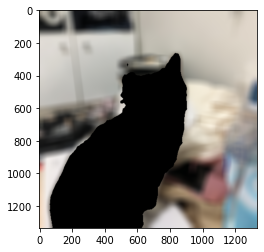

In [21]:
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_cat_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

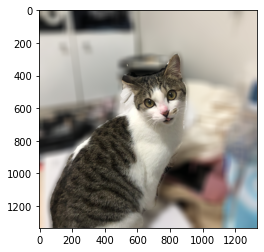

In [22]:
img_concat = np.where(img_mask_color==255, img_cat, img_cat_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

## 7. 문제점 분석

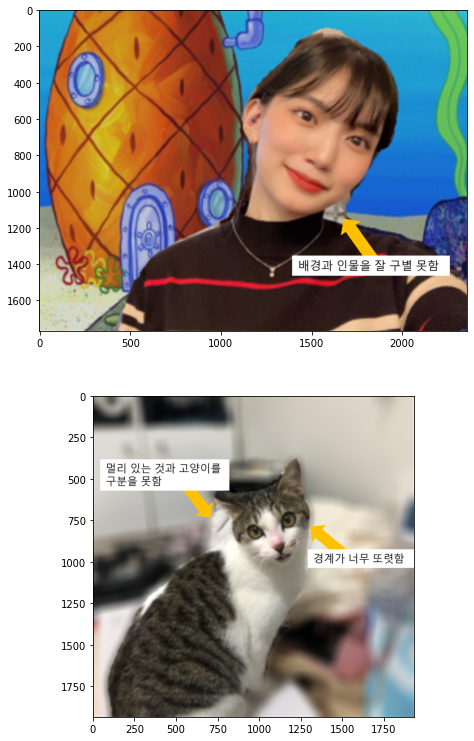

In [23]:
img_p1 = cv2.imread("/content/gdrive/MyDrive/Data/문제1.png")
img_p2 = cv2.imread("/content/gdrive/MyDrive/Data/문제2.png")
fig = plt.figure(figsize=(20,13))
ax1 = fig.add_subplot(2,1,1)
ax2 = fig.add_subplot(2,1,2)
ax1.imshow(cv2.cvtColor(img_p1, cv2.COLOR_BGR2RGB))
ax2.imshow(cv2.cvtColor(img_p2, cv2.COLOR_BGR2RGB))
plt.show()

1. 배경과 인물을 잘 구별하지 못한다.
2. 경계가 너무 또렷하다

## 8. 해결 방법 

### 8.1 배경과 인물을 구별하지 못하는 문제

배경과 인물을 구분하려면 깊이(Depth)만한게 없는 것 같다.  
깊이를 알기 위해서는 LiDAR, ToF, 구조광에 기반한 __센서로 거리를 측정한 방법__과 입력 영상을 __학습 데이터에 기반하여 거리 측정__을 수행하는 방법이다. 예는 MonoDepth2가 있다.  
위와 같이 LiDAR나 ToF, MonoDepth를 이용하여 배경과 인물을 좀 더 잘 구분 할 수 있도록 하게 한다.

### 8.2 경계가 너무 또렷한 문제

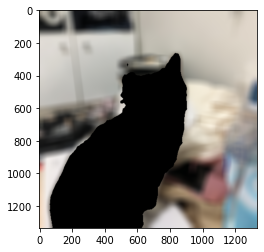

In [24]:
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_cat_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

위와 같이 mask가 또렷히 경계가 져서 좀 부 자연스러운 것을 볼 수 가 있다. 그래서 이 마스크 자체를 또 블러(가우시안)를 해주면 좀더 자연스러운 영상이 될 것이다.

## 회고 
- 내폰은 Se2로 카메라가 한개 인데 인물사진 모드가 된다. 하드웨어적인 부분을 업그레이드 하지 않아도 소프트웨어만 바꿈으로써 이러한 기술이 가능 하다는 것이 신기했다.
- CS231n에서도 Image Segmentation 강의를 다루는데 다는 못봤지만,, 나중에 봐야지,,ㅎㅎ
https://www.youtube.com/watch?v=nDPWywWRIRo